# Modelo de Aprendizaje Automático

- **Objetivo**: Predecir los días de atraso de pagos de los clientes.  
- **Base de datos**: Información interna de una empresa en la que trabajé previamente (uso confidencial).  
- **Estado del proyecto**: Proyecto inicial en fase exploratoria, desarrollado principalmente con fines de aprendizaje.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [71]:
# Obteniendo tablas de interes.

df_cancel=pd.read_excel("D:/GRUPO VALLE/RIESGOS Y COBRANZAS/DIARIO/CREDITOS_VIGENTES.xlsm",sheet_name="CANCELADOS",dtype={"DNI":str})
# df_cancel.head(3)
df_desem=pd.read_excel("D:/GRUPO VALLE/RIESGOS Y COBRANZAS/DIARIO/CREDITOS_VIGENTES.xlsm",sheet_name="DESEMBOLSO",dtype={"DNI":str})
# df_desem.head(3)
df_clientes=pd.read_excel("D:/GRUPO VALLE/RIESGOS Y COBRANZAS/DIARIO/CREDITOS_VIGENTES.xlsm",sheet_name="CLIENTES",dtype={"DNI":str})
# df_clientes.head(2)

Analisis exploratorio de datos

In [72]:
# Obteniendo variables de interes

df_clientes=df_clientes[["DNI","SEXO",]]
df_desem=df_desem[["ID_CREDITO","N_C_PARALELOS","MONTO_C_PARALELOS","N_RENOVACIONES"]]
df_cancel=df_cancel[["DNI","ID_CREDITO","CATEGORIA","MONTO_DESEM","ATRASO"]]

In [73]:
# Uniendo a una sola tabla

df=pd.merge(df_cancel,df_clientes,how="left",on="DNI") #agregando caracteristicas del cliente
df=pd.merge(df,df_desem,how="left",on="ID_CREDITO") #agregando caracteristicas del crédito
df.head()

,DNI,ID_CREDITO,CATEGORIA,MONTO_DESEM,ATRASO,SEXO,N_C_PARALELOS,MONTO_C_PARALELOS,N_RENOVACIONES
0,41122295,1373,ELECTRO,400.0,1,F,1.0,1200.0,NaN
1,42441581,1374,ELECTRO,150.0,3,M,0.0,0.0,NaN
2,41122295,1372,TECNOLOGIA,70.0,1,F,1.0,1200.0,NaN
3,20069053,1400,VEHICULAR,1500.0,-9,M,1.0,3500.0,NaN
4,20024095,1460,TARJETA,900.0,-30,F,0.0,0.0,0.0


In [74]:
# Tipos de datos
print(df.shape)
print(df.dtypes)

(1779, 9)
DNI                   object
ID_CREDITO             int64
CATEGORIA             object
MONTO_DESEM          float64
ATRASO                 int64
SEXO                  object
N_C_PARALELOS        float64
MONTO_C_PARALELOS    float64
N_RENOVACIONES       float64
dtype: object


In [75]:
# Verificando valores nulos

print("# Nulos \n",df.isna().sum())
print("% Nulos \n",(df.isna().sum()/len(df))*100)

# Nulos 
 DNI                   0
ID_CREDITO            0
CATEGORIA             0
MONTO_DESEM           0
ATRASO                0
SEXO                  0
N_C_PARALELOS         2
MONTO_C_PARALELOS     2
N_RENOVACIONES       71
dtype: int64
% Nulos 
 DNI                  0.000000
ID_CREDITO           0.000000
CATEGORIA            0.000000
MONTO_DESEM          0.000000
ATRASO               0.000000
SEXO                 0.000000
N_C_PARALELOS        0.112423
MONTO_C_PARALELOS    0.112423
N_RENOVACIONES       3.991006
dtype: float64


In [76]:
# Observando los valores nulos

df[df["N_C_PARALELOS"].isna()]

,DNI,ID_CREDITO,CATEGORIA,MONTO_DESEM,ATRASO,SEXO,N_C_PARALELOS,MONTO_C_PARALELOS,N_RENOVACIONES
289,06528848,1654,ELECTRO,400.0,0,M,NaN,NaN,NaN
458,47585699,1979,TARJETA,285.0,-26,M,NaN,NaN,NaN


In [77]:
# Eliminamos los datos perdidos porque no hay forma de recuperarlos

df=df.dropna()
print(df.isna().sum())
print(df.shape)

DNI                  0
ID_CREDITO           0
CATEGORIA            0
MONTO_DESEM          0
ATRASO               0
SEXO                 0
N_C_PARALELOS        0
MONTO_C_PARALELOS    0
N_RENOVACIONES       0
dtype: int64
(1708, 9)


In [78]:
# Eliminamos las garantías que tienen por categoría "Tarjetas" debido a que sus dias de atraso son determinantes

df=df[df["CATEGORIA"]!="TARJETA"]
df=df.drop(columns=["DNI","ID_CREDITO"]) #eliminamos las variables que no necesitamos.
df_0=df.copy() #copiamos nuestro dataframe para entrenar nuestro pipeline más adelante

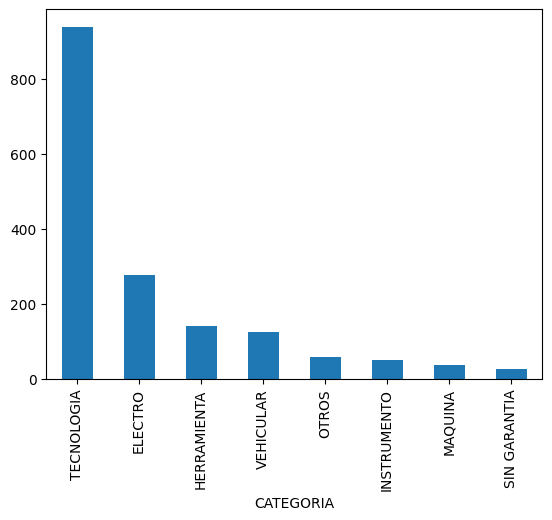

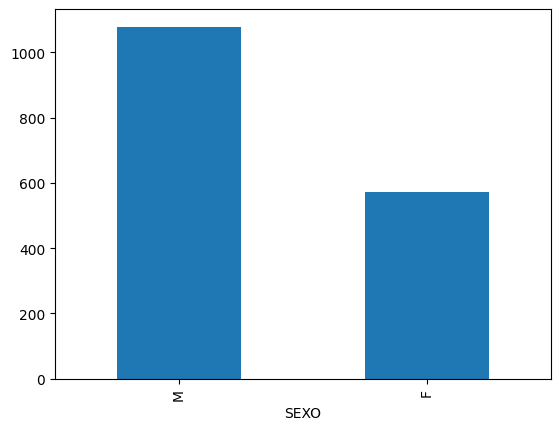

In [79]:
# Observamos las distribución de las variables categoricas

categoricas = df.select_dtypes("object").columns  # Agrega más si tienes
# Graficamos rápidamente
for col in categoricas:
    df_0[col].value_counts().plot(kind='bar')
    plt.show()


In [80]:
# Observando los datos numericos
df.describe()

,MONTO_DESEM,ATRASO,N_C_PARALELOS,MONTO_C_PARALELOS,N_RENOVACIONES
count,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000
mean,586.931295,0.293584,0.642857,383.072458,1.723366
std,767.162363,15.354061,1.230366,1252.067850,2.663273
min,20.000000,-32.000000,0.000000,0.000000,0.000000
25%,200.000000,-4.000000,0.000000,0.000000,0.000000
50%,350.000000,1.000000,0.000000,0.000000,1.000000
75%,600.000000,6.000000,1.000000,300.000000,2.000000
max,6300.000000,139.000000,8.000000,19050.000000,20.000000


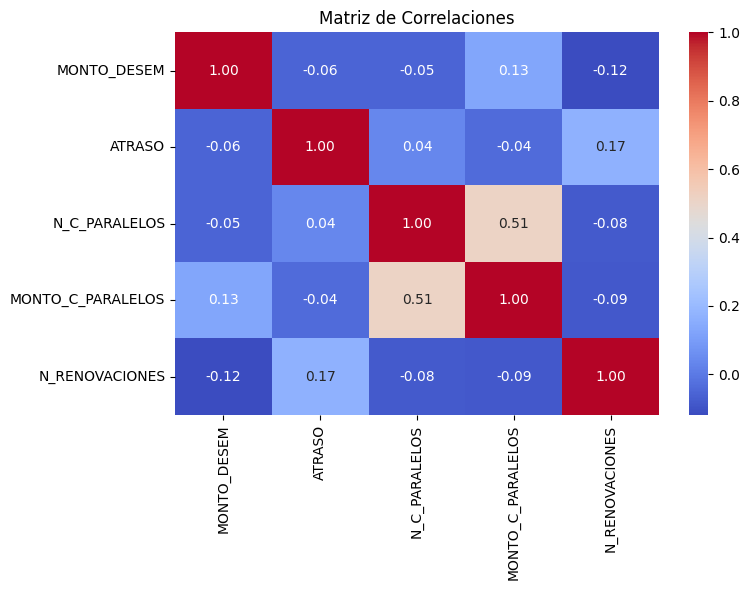

In [81]:
# Observamos las relaciones entre variables

import seaborn as sns
df_numeric = df.select_dtypes(include='number')
correlation_matrix = df_numeric.corr()

# Dibuja el mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlaciones")
plt.tight_layout()
plt.show()

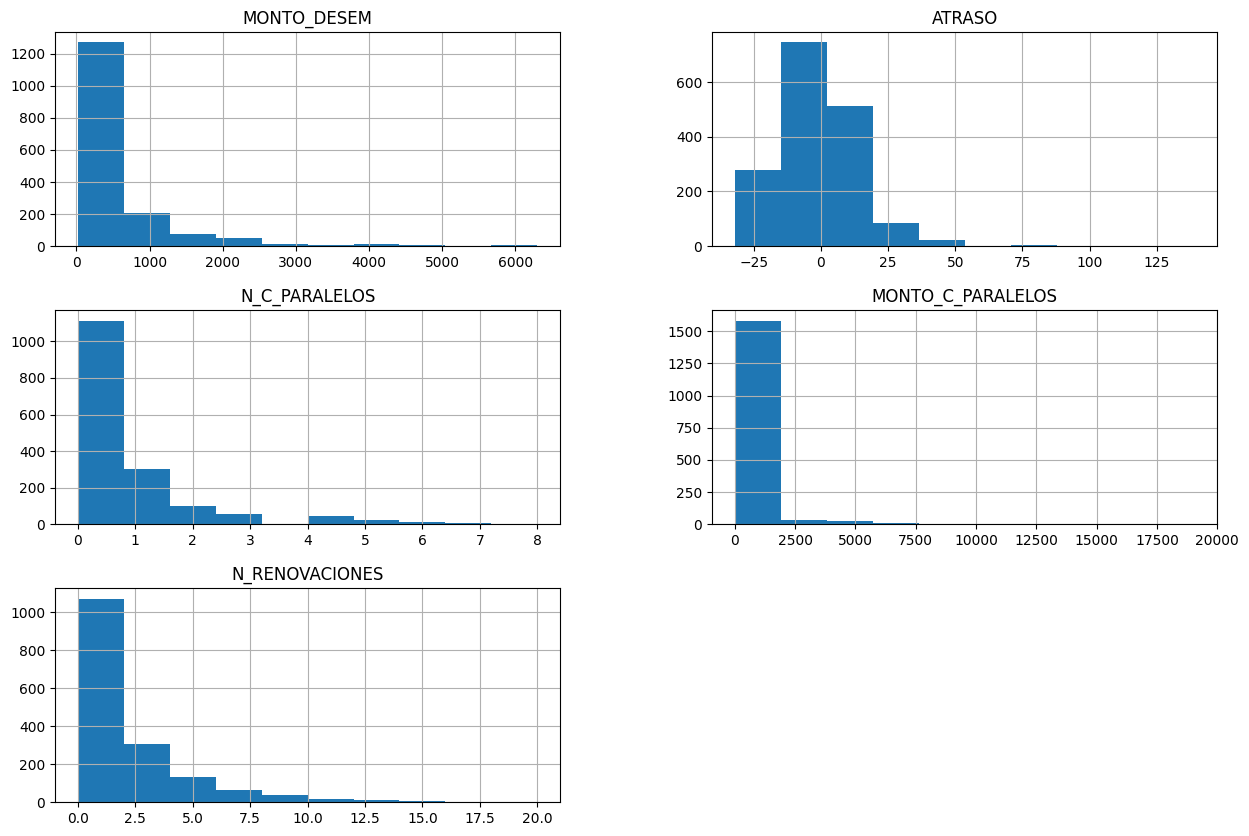

In [82]:
# Observamos la distribución de variables

df.hist(figsize=(15,10))
plt.show()

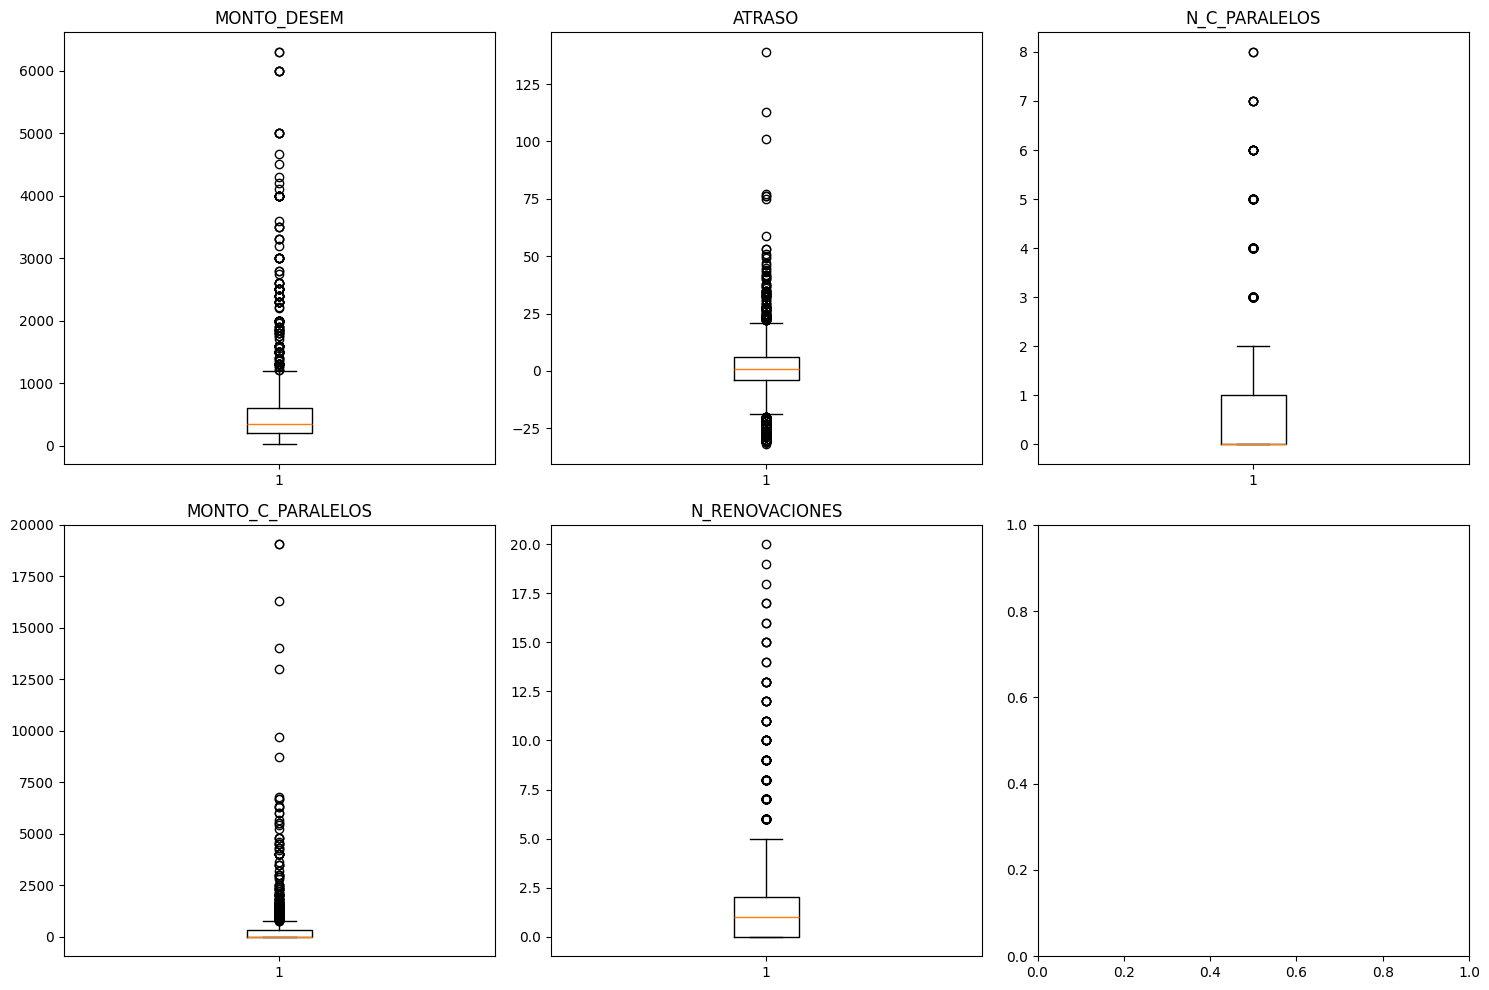

In [83]:
# Observando outliers

cols = df.select_dtypes(include='number').columns
# Crear subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # Para recorrerlos fácilmente

# Creando boxplot por variable
for i, col in enumerate(cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

Pre Procesamiento

In [84]:
# Preprocesamiento
# Transformación logaritmica: Correcto para corregir asimetrias en los valores monetarios
df["MONTO_DESEM"]=np.log(df["MONTO_DESEM"]+1)
df["MONTO_C_PARALELOS"]=np.log(df["MONTO_C_PARALELOS"]+1)

# Estandarización: Correcto para que las variables esten comparables y no favorezca a variables con valores altos
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
col_num=["MONTO_DESEM","MONTO_C_PARALELOS","N_C_PARALELOS","N_RENOVACIONES"]
df[col_num]=scaler.fit_transform(df[col_num])

#obteniendo dummies para nuestras variables categoricas
df=pd.get_dummies(df,columns=["CATEGORIA","SEXO"],drop_first=True)

Buscando el mejor modelo de Machine learning

In [85]:
# Importamos las metricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Creamos nuestra base de datos para ver las metricas
resultados=pd.DataFrame(columns=["MODELO","MAE","RMSE","R2"])

# Separando en datos de entrenamiento y testeo
from sklearn.model_selection import train_test_split
train_m1,test_m1=train_test_split(df,random_state=100,test_size=0.10)

# Separamos nuestra variable independiente y dependiente
train_m1_x=train_m1.drop(columns=["ATRASO"])
train_m1_y=train_m1["ATRASO"]
test_m1_x=test_m1.drop(columns=["ATRASO"])
test_m1_y=test_m1["ATRASO"]

In [86]:
# Modelo 1: Regresión lineal
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(train_m1_x,train_m1_y)

#Evaluación del modelo
y_pred=lr.predict(test_m1_x)

print("MAE:", mean_absolute_error(test_m1_y,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(test_m1_y, y_pred)))
print("R²:", r2_score(test_m1_y, y_pred))

# Guardamos
resultados.loc[0,"MODELO"]="LINEAR"
resultados.loc[0,"MAE"]=mean_absolute_error(test_m1_y,y_pred)
resultados.loc[0,"RMSE"]=np.sqrt(mean_squared_error(test_m1_y, y_pred))
resultados.loc[0,"R2"]=r2_score(test_m1_y, y_pred)

MAE: 8.929399837686438
RMSE: 11.99553280627005
R²: 0.1074325954457972


In [87]:
# Modelo 2: Decision tree
from sklearn.tree import DecisionTreeRegressor
dt=DecisionTreeRegressor()
dt.fit(train_m1_x,train_m1_y)

#Evaluación del modelo
y_pred=dt.predict(test_m1_x)

print("MAE:", mean_absolute_error(test_m1_y,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(test_m1_y, y_pred)))
print("R²:", r2_score(test_m1_y, y_pred))

#Guardamos
resultados.loc[1,"MODELO"]="DESICION_TREE"
resultados.loc[1,"MAE"]=mean_absolute_error(test_m1_y,y_pred)
resultados.loc[1,"RMSE"]=np.sqrt(mean_squared_error(test_m1_y, y_pred))
resultados.loc[1,"R2"]=r2_score(test_m1_y, y_pred)

MAE: 9.801997332339289
RMSE: 14.276682188182525
R²: -0.26431858209671133


In [88]:
# Modelo 3: Random forest
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(random_state=43)
rf.fit(train_m1_x,train_m1_y)

#Evaluación del modelo
y_pred=rf.predict(test_m1_x)

print("MAE:", mean_absolute_error(test_m1_y,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(test_m1_y, y_pred)))
print("R²:", r2_score(test_m1_y, y_pred))

#Guardamos
resultados.loc[2,"MODELO"]="RANDOM_FOREST"
resultados.loc[2,"MAE"]=mean_absolute_error(test_m1_y,y_pred)
resultados.loc[2,"RMSE"]=np.sqrt(mean_squared_error(test_m1_y, y_pred))
resultados.loc[2,"R2"]=r2_score(test_m1_y, y_pred)

MAE: 9.099770525733954
RMSE: 12.716439852977414
R²: -0.003074107795670189


In [89]:
# Modelo 4 : Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(random_state=9)
gb.fit(train_m1_x,train_m1_y)

# Evaluación del modelo
y_pred=gb.predict(test_m1_x)

print("MAE:", mean_absolute_error(test_m1_y,y_pred))
print("RMSE:", np.sqrt(mean_squared_error(test_m1_y, y_pred)))
print("R²:", r2_score(test_m1_y, y_pred))

# Guardamos
resultados.loc[3,"MODELO"]="GRADIENT BOOSTING"
resultados.loc[3,"MAE"]=mean_absolute_error(test_m1_y,y_pred)
resultados.loc[3,"RMSE"]=np.sqrt(mean_squared_error(test_m1_y, y_pred))
resultados.loc[3,"R2"]=r2_score(test_m1_y, y_pred)

MAE: 8.699406025294053
RMSE: 12.313575302429427
R²: 0.05947514180097768


In [90]:
# Observamos los resultados
resultados

,MODELO,MAE,RMSE,R2
0,LINEAR,8.9294,11.995533,0.107433
1,DESICION_TREE,9.801997,14.276682,-0.264319
2,RANDOM_FOREST,9.099771,12.71644,-0.003074
3,GRADIENT BOOSTING,8.699406,12.313575,0.059475


In [91]:
# El mejor modelo base es el modelo lineal y gradient boosting

Optimización del modelo

In [92]:
# Optimizando el modelo

from sklearn.model_selection import GridSearchCV
parametros = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(estimator=gb, #nuestro modelo base
                           param_grid=parametros, #los parametros
                           cv=5, 
                           scoring='neg_root_mean_squared_error',  # o 'neg_mean_squared_error'
                           n_jobs=-1, #usa todos los nucleos para optimizar
                           verbose=2)

grid_search.fit(train_m1_x, train_m1_y) #optimizamos el modelo

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score (RMSE negativo):", grid_search.best_score_)

mejor_modelo = grid_search.best_estimator_ # guardamos el mejor modelo
y_pred = mejor_modelo.predict(test_m1_x) # testeamos el mejor modelo
rmse = np.sqrt(mean_squared_error(test_m1_y, y_pred)) #RMSE del modelo
print("RMSE en test:", rmse) 


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Mejor score (RMSE negativo): -14.705687637978105
RMSE en test: 12.27702790064468


In [93]:
#obtener el modelo entrenado con todo el dataset

from sklearn.ensemble import GradientBoostingRegressor

mejor_modelo = GradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=2,
    n_estimators=100,
    subsample=0.8
)

mejor_modelo.fit(X=df.drop(columns=["ATRASO"]), y=df["ATRASO"])  # Entrena con todo el dataset

GradientBoostingRegressor(learning_rate=0.05, subsample=0.8)

In [94]:
# Guardamos el modelo optimizado:
import joblib
joblib.dump(mejor_modelo, 'modelo_gb.pkl')

['modelo_gb.pkl']

Mandar a producción el modelo

In [95]:
# Realizamos Encapsulamos nuestro modelo

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

# Define las columnas
col_log = ["MONTO_DESEM", "MONTO_C_PARALELOS"]
col_numericas = ["N_C_PARALELOS","N_RENOVACIONES"] 
col_categoricas = ["CATEGORIA", "SEXO"]

# Paso de logaritmo
log_scaler = Pipeline([
    ('log', FunctionTransformer(np.log1p)),
    ('scaler', StandardScaler())
])

# Estandarizar el resto de las columnas
num_scaler = Pipeline([
    ('scaler', StandardScaler())
])


# Preprocesamiento de columnas
preprocesamiento = ColumnTransformer([
    ('log_scaled', log_scaler, col_log),
    ('num_scaled', num_scaler, col_numericas),
    ('cat', OneHotEncoder(drop='first'), col_categoricas)
])

# Pipeline completo
pipeline = Pipeline([
    ('preprocesamiento', preprocesamiento),
    ('modelo', GradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=3,
        min_samples_split=2,
        n_estimators=100,
        subsample=0.8
    ))
])

# Entrena el pipeline
pipeline.fit(X=df_0.drop(columns=["ATRASO"]),y=df_0["ATRASO"])


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('log_scaled',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MONTO_DESEM',
                                                   'MONTO_C_PARALELOS']),
                                                 ('num_scaled',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['N_C_PARALELOS',
                                                   'N_RENOVACIONES']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['CATEGORIA', 'SEXO'])])),
                ('modelo',
                 GradientBoostingRegressor(learning_rate=0.05, subsample=0.8))])

In [96]:
# Guardar pipeline
import joblib
joblib.dump(pipeline, 'modelo_pipeline.pkl')

['modelo_pipeline.pkl']

Predecimos

In [114]:
# Creamos datos nuevos para usar el modelo

nuevos=pd.DataFrame(columns=df_0.columns)
nuevos=nuevos.drop(columns=["ATRASO"])
lista=["VEHICULAR",2000,"M",5,2000,6]
nuevos.loc[0]=lista
nuevos

,CATEGORIA,MONTO_DESEM,SEXO,N_C_PARALELOS,MONTO_C_PARALELOS,N_RENOVACIONES
0,VEHICULAR,2000,M,5,2000,6


In [115]:
modelo = joblib.load('modelo_pipeline.pkl')
modelo.predict(nuevos)

array([15.77931652])

- **Recomendaciones**:  
Para mejorar el modelo, se debe iniciar la recolección de información importante de otras características relacionadas tanto al cliente como al crédito, tales como la edad, la actividad económica, la situación laboral, si cuenta con deudas en el sistema financiero tradicional, el monto de dichas deudas, entre otras.